# About this kernel

In this kernel I propose a simple algorithm that I came up with to improve the current best LB score. 

Here's a simple description of the algorithm, which is defined as `stochastic_product_search`:
1. Sample a small number of families (e.g. 6 families), call this `fam_size`, or f.
2. Given their top-k choices (e.g. two most preferred days), you find the cartesian product of those choices.
3. That will give you k^f (or in the example above 2^6 = 64) possible changes that you can make to your current assignment. For each of those proposed change, you create a `new` assignment by updating your current `best` assignment. If the `new_score` is better than the current `best_score`, update both of those values.
4. Repeat that for the number of iterations desired, given by parameter `n_iter`.


## References
* Current Best LB Score: https://www.kaggle.com/vipito/santa-ip


In [117]:
from itertools import product

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from numba import njit, prange
import os
from functools import partial


In [118]:
# Load Data
base_path = '/kaggle/input/santa-workshop-tour-2019/'
sub_path = '../input/santa-requires-more-time-to-find-bad-kids/'
data = pd.read_csv(base_path + 'family_data.csv', index_col='family_id')
submission = pd.read_csv(sub_path + '/submission.csv', index_col='family_id')

In [119]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

family_size = data.n_people.values
days_array = np.arange(N_DAYS, 0, -1)
choice_dict = data.loc[:, 'choice_0': 'choice_9'].T.to_dict()

choice_array_num = np.full((data.shape[0], N_DAYS + 1), -1)
for i, choice in enumerate(data.loc[:, 'choice_0': 'choice_9'].values):
    for d, day in enumerate(choice):
        choice_array_num[i, day] = d
        
penalties_array = np.array([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(family_size.max() + 1)
])

@njit(fastmath=True) # fast math makes it a bit quicker, but less accurate
def cost_function_detailed(prediction, penalties_array, family_size, days):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros((len(days)+1))
    N = family_size.shape[0]
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for i in range(N):
        # add the family member count to the daily occupancy
        n = family_size[i]
        d = prediction[i]
        choice = choice_array_num[i]
        
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        penalty += penalties_array[n, choice[d]]

    choice_cost = penalty
        
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    relevant_occupancy = daily_occupancy[1:]
    incorrect_occupancy = np.any(
        (relevant_occupancy > MAX_OCCUPANCY) | 
        (relevant_occupancy < MIN_OCCUPANCY)
    )
    
    if incorrect_occupancy:
        penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = np.abs(today_count - yesterday_count)
        accounting_cost += max(0, (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty, choice_cost, accounting_cost




In [120]:


# Build your "cost_function"
#cost_function = build_cost_function(data)

# Run it on default submission file
original = submission['assigned_day'].values
original_score = cost_function_detailed(original,penalties_array, family_size, days_array)

%timeit cost_function_detailed(original,penalties_array, family_size, days_array)

35.6 µs ± 4.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [121]:
original_score

(69827.70384985393, 64346, 5481.703849853936)

# Novel Algorithm

In [122]:
def stochastic_product_search(top_k, fam_size, original, choice_matrix, 
                              disable_tqdm=False, verbose=10000,
                              n_iter=500, random_state=2019):
    """
    original (np.array): The original day assignments.
    
    At every iterations, randomly sample fam_size families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^fam_size products.
    """
    
    best = original.copy()
    best_score = cost_function_detailed(best, penalties_array, family_size, days_array)[0]
    print("!!!!! current best score: ", best_score)
    np.random.seed(random_state)

    for i in tqdm(range(n_iter), disable=disable_tqdm):
        fam_indices = np.random.choice(range(choice_matrix.shape[0]), size=fam_size)
        #print("fam indice: ", fam_indices)
        changes = np.array(list(product(*choice_matrix[fam_indices, :top_k].tolist())))

        for change in changes:
            #print(change)
            new = best.copy()
            new[fam_indices] = change

            new_score = cost_function_detailed(new,penalties_array, family_size, days_array)[0]
            #print(new_score)
            #print(validate_occupancy(new,data))
            validate = validate_occupancy(new,data)
            if new_score < best_score and new_score > 0:
                if(validate_occupancy(new,data)):
                    print("fam indice: ", fam_indices)
                    print("---- changed new score: ", new_score)
                    best_score = new_score
                    best = new
        
        if new_score < best_score and new_score > 0:
            if(validate_occupancy(new,data)):
                best_score = new_score
                best = new
    
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}")
    
    print(f"Final best score is {best_score:.2f}")
    return best

In [123]:
def validate_occupancy(sub, data):
    #sub is family selection with length of 5000
    fam_size = data["n_people"]
    day_occupancy = np.zeros(101) # starts from 1
    for fid, day in enumerate(sub):
        day_occupancy[day] = day_occupancy[day] + fam_size[fid]

    #print(day_occupancy)
    
    for day, peoplenum in enumerate(day_occupancy):
        if day == 0:
            continue
        if peoplenum > 300 or peoplenum < 125:
            #print("day: ", day, " number of visitor: ", peoplenum)
            return False
    return True

In [124]:
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values

In [ ]:
test = stochastic_product_search(
    choice_matrix=choice_matrix, 
    top_k=2,
    fam_size=2, 
    original=original, 
    n_iter=500,
    disable_tqdm=False,
    verbose=20
)

!!!!! current best score:  69827.70384985393


Iteration #0: Best score is 69827.70
Iteration #20: Best score is 69827.70


In [ ]:
validate_occupancy(test,data)

In [ ]:
def gradual_decrease_stochastic(original, top_k_start=8, fam_size_start=5, 
                                iter_per_descent=1, disable_tqdm=False, verbose=10):
    
    # first iteration
    best = stochastic_product_search(
    choice_matrix=choice_matrix, 
    top_k=top_k_start,
    fam_size=fam_size_start, 
    original=original, 
    n_iter=iter_per_descent,
    disable_tqdm=disable_tqdm,
    verbose=verbose)
    
    temp_fam_size = fam_size_start
    #print("start gradual stochastic!!")
    for top_k in range(top_k_start-1,2,-1):
        
        #print("top_k : ", top_k , "fam_size : ", temp_fam_size)
        best = stochastic_product_search(choice_matrix=choice_matrix, top_k=top_k,fam_size=temp_fam_size, 
                                         original=best, n_iter=iter_per_descent,
                                         disable_tqdm=disable_tqdm,verbose=verbose)
        temp_fam_size -= 1
        #print("top_k : ", top_k , "fam_size : ", temp_fam_size)
        if temp_fam_size == 1:
            break
        best = stochastic_product_search(choice_matrix=choice_matrix, top_k=top_k,fam_size=temp_fam_size, 
                                         original=best, n_iter=iter_per_descent,
                                         disable_tqdm=disable_tqdm,verbose=verbose)
    
    return best

# Usage

## Round 1

In [ ]:
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values

In [ ]:
choice_matrix

In [113]:
best = gradual_decrease_stochastic(test, top_k_start=2, fam_size_start=5, 
                            iter_per_descent=2, disable_tqdm=False, verbose=1)

!!!!! current best score:  69827.70384985393


Iteration #0: Best score is 69827.70
Iteration #1: Best score is 69827.70

Final best score is 69827.70
!!!!! current best score:  69827.70384985393


Iteration #0: Best score is 69827.70
Iteration #1: Best score is 69827.70

Final best score is 69827.70
!!!!! current best score:  69827.70384985393


Iteration #0: Best score is 69827.70
Iteration #1: Best score is 69827.70

Final best score is 69827.70


## Round 2

In [114]:
best = stochastic_product_search(
    choice_matrix=choice_matrix, 
    top_k=3,
    fam_size=2, 
    original=best, 
    n_iter=100, 
    disable_tqdm=True,
    verbose=1
)

!!!!! current best score:  69827.70384985393
Iteration #0: Best score is 69827.70
Iteration #1: Best score is 69827.70
Iteration #2: Best score is 69827.70
Iteration #3: Best score is 69827.70
Iteration #4: Best score is 69827.70
Iteration #5: Best score is 69827.70
Iteration #6: Best score is 69827.70
Iteration #7: Best score is 69827.70
Iteration #8: Best score is 69827.70
Iteration #9: Best score is 69827.70
Iteration #10: Best score is 69827.70
Iteration #11: Best score is 69827.70
Iteration #12: Best score is 69827.70
Iteration #13: Best score is 69827.70
Iteration #14: Best score is 69827.70
Iteration #15: Best score is 69827.70
Iteration #16: Best score is 69827.70
Iteration #17: Best score is 69827.70
Iteration #18: Best score is 69827.70
Iteration #19: Best score is 69827.70
Iteration #20: Best score is 69827.70
Iteration #21: Best score is 69827.70
Iteration #22: Best score is 69827.70
Iteration #23: Best score is 69827.70
Iteration #24: Best score is 69827.70
Iteration #25: 

## Round 3

In [ ]:
best = stochastic_product_search(
    choice_matrix=choice_matrix, 
    top_k=7,
    fam_size=2, 
    original=best,
    n_iter=50, 
    disable_tqdm=True,
    verbose=2
)

# TEMP SAVE


In [116]:
submission['assigned_day'] = best
submission.to_csv(f'submission_sto.csv')

# visualization

In [89]:
import seaborn as sns

import matplotlib.pyplot as plt
from numba import njit

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)

In [90]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

family_size = data.n_people.values
days_array = np.arange(N_DAYS, 0, -1)
choice_dict = data.loc[:, 'choice_0': 'choice_9'].T.to_dict()

choice_array_num = np.full((data.shape[0], N_DAYS + 1), -1)
for i, choice in enumerate(data.loc[:, 'choice_0': 'choice_9'].values):
    for d, day in enumerate(choice):
        choice_array_num[i, day] = d
        
penalties_array = np.array([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(family_size.max() + 1)
])

In [91]:
@njit(fastmath=True) # fast math makes it a bit quicker, but less accurate
def cost_function_detailed(prediction, penalties_array, family_size, days):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros((len(days)+1))
    N = family_size.shape[0]
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for i in range(N):
        # add the family member count to the daily occupancy
        n = family_size[i]
        d = prediction[i]
        choice = choice_array_num[i]
        
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        penalty += penalties_array[n, choice[d]]

    choice_cost = penalty
        
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    relevant_occupancy = daily_occupancy[1:]
    incorrect_occupancy = np.any(
        (relevant_occupancy > MAX_OCCUPANCY) | 
        (relevant_occupancy < MIN_OCCUPANCY)
    )
    
    if incorrect_occupancy:
        penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = np.abs(today_count - yesterday_count)
        accounting_cost += max(0, (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty, choice_cost, accounting_cost


In [92]:
def calculate_df(original_df, pred):
    new_df = original_df.copy()
    new_df['assigned_day'] = pred
    new_df['choice'] = 0
    for c in range(10):
        new_df.loc[new_df[f'choice_{c}'] == new_df['assigned_day'], 'choice'] = c
    
    new_df['choice_cost'] = new_df.apply(lambda x: penalties_array[x['n_people']][x['choice']], axis=1)
    
    for c in range(10):
        new_df[f'n_people_{c}'] = np.where(new_df[f'choice_{c}'] == new_df['assigned_day'], new_df['n_people'], 0)
        
    for c in range(1, 10):
        d = c -1
        new_df[f'n_people_{c}'] = new_df[f'n_people_{d}'] + new_df[f'n_people_{c}']
        
    aggdata = new_df.groupby(by=['assigned_day'])['n_people', 'n_people_0', 'n_people_1', 'n_people_2', 'n_people_3', 'n_people_4', 'n_people_5', 'n_people_6', 'n_people_7', 'n_people_8', 'n_people_9', 'choice_cost'].sum().reset_index()
    
    daily_occupancy = aggdata['n_people'].values
    accounting_cost_daily = np.zeros(len(daily_occupancy))
    for day in range(N_DAYS-1, -1, -1):
        if day == 99:
            n_next = 125.0
        else:
            n_next = daily_occupancy[day + 1]
        n = daily_occupancy[day]
        diff = abs(n - n_next)
        accounting_cost_daily[day] = max(0, (n-125.0) / 400.0 * n**(0.5 + diff / 50.0))

    aggdata['accounting_cost'] = accounting_cost_daily
    aggdata['total_cost'] = aggdata['choice_cost'] + aggdata['accounting_cost']
    aggdata['accounting_cost']=aggdata['accounting_cost'].astype(int)
    aggdata['total_cost']=aggdata['total_cost'].astype(int)
   
    new_df = pd.merge(left=new_df, right=aggdata[['assigned_day', 'n_people']].rename(columns={'n_people': 'n_people_per_day'}), on='assigned_day')
    
    return new_df, aggdata


you can choose your range here

In [93]:
MIN_OCCUPANCY = 0
MAX_OCCUPANCY = 400
MIN_COST = 0
MAX_COST = 3000


In [94]:
def plot_both(data, pred):
    _, adata3 = calculate_df(data.copy(), pred.copy())

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 18), sharey=True)
    sns.set_color_codes("pastel")

    sns.barplot(x='n_people_9', y='assigned_day', data=adata3, label='choice_9', orient='h', color='m', ax=ax1)
    sns.barplot(x='n_people_8', y='assigned_day', data=adata3, label='choice_8', orient='h', color='grey', ax=ax1)
    sns.barplot(x='n_people_7', y='assigned_day', data=adata3, label='choice_7', orient='h', color='orange', ax=ax1)
    sns.barplot(x='n_people_6', y='assigned_day', data=adata3, label='choice_6', orient='h', color='olive', ax=ax1)
    sns.barplot(x='n_people_5', y='assigned_day', data=adata3, label='choice_5', orient='h', color='k', ax=ax1)
    sns.barplot(x='n_people_4', y='assigned_day', data=adata3, label='choice_4', orient='h', color='r', ax=ax1)
    sns.barplot(x='n_people_3', y='assigned_day', data=adata3, label='choice_3', orient='h', color='y', ax=ax1)
    sns.barplot(x='n_people_2', y='assigned_day', data=adata3, label='choice_2', orient='h', color='g', ax=ax1)
    sns.barplot(x='n_people_1', y='assigned_day', data=adata3, label='choice_1', orient='h', color='c', ax=ax1)
    sns.barplot(x='n_people_0', y='assigned_day', data=adata3, label='choice_0', orient='h', color='b', ax=ax1)
    ax1.axvline(125, color="k", clip_on=False)
    ax1.axvline(300, color="k", clip_on=False)
    ax1.axvline(210, color="k", clip_on=False, linestyle='--')
    ax1.legend(ncol=2, loc="lower right", frameon=True)
    ax1.set(xlabel="Occupancy")
    ax1.set_xlim(MIN_OCCUPANCY, MAX_OCCUPANCY)

    total_cost, choice_cost, acc_cost = cost_function_detailed(pred, penalties_array, family_size, days_array)
    
    sns.set_color_codes("deep")
    sns.barplot(x='total_cost', y='assigned_day', data=adata3, label='total_cost', orient='h', color='k', ax=ax2)
    sns.barplot(x='choice_cost', y='assigned_day', data=adata3, label='choice_cost', orient='h', color='r', ax=ax2)
    sns.barplot(x='accounting_cost', y='assigned_day', data=adata3, label='accounting_cost', orient='h', color='y', ax=ax2)
    ax2.legend(ncol=2, loc="lower right", frameon=True)
    ax2.set(xlabel=f"Costs: {choice_cost:.0f} + {acc_cost:.0f} = {total_cost:.0f}")
    ax2.set_xlim(MIN_COST, MAX_COST)


In [95]:
data = pd.read_csv('../input/santa-workshop-tour-2019/family_data.csv')

sub = pd.read_csv("submission_temp.csv", index_col='family_id', dtype=np.uint16)
sample = pd.read_csv("../input/santa-workshop-tour-2019/sample_submission.csv", index_col='family_id', dtype=np.uint16)

# I'll add the submission assigned day to the family dataset
data['assigned_day'] = sub['assigned_day']

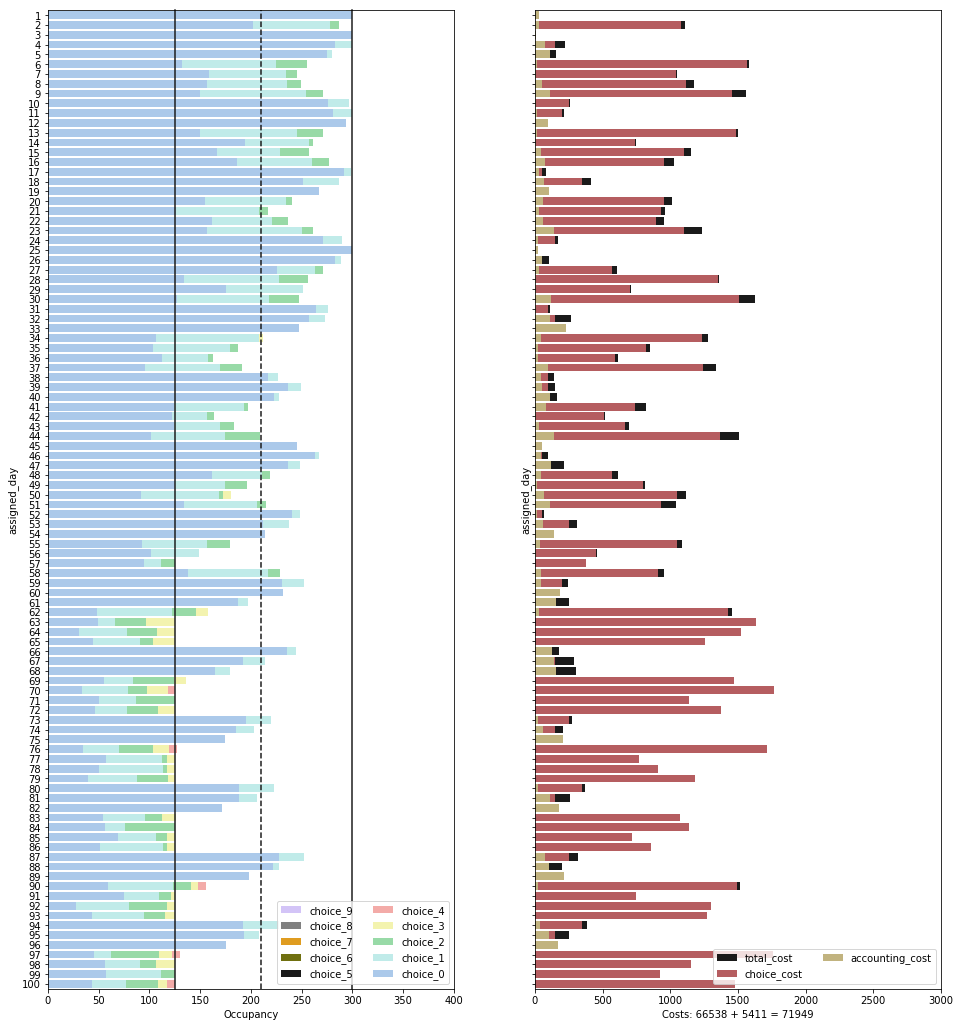

In [96]:
plot_both(data.copy(), data['assigned_day'].values)


In [ ]:
# find what is the main cost cause

plot_both(data.copy(), data['assigned_day'].values)


# Save

In [51]:
submission['assigned_day'] = best
submission.to_csv('submission_1000.csv')